In [2]:
!git clone https://github.com/imostafizur/CSE498R.git

fatal: destination path 'CSE498R' already exists and is not an empty directory.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

In [4]:
image = 'Pneumonia'

In [5]:
print('Number of images in each folder:')
for folder in os.listdir(image):
    print(folder, len(os.listdir(os.path.join(image, folder))))

Number of images in each folder:
NORMAL 1342
PNEUMONIA 3876


In [6]:
# Create a dataframe with the image names and their labels
df = pd.DataFrame(columns=['image', 'label'])
for folder in os.listdir(image):

    for file in os.listdir(os.path.join(image, folder)):
        df = df.append({'image': os.path.join(image, folder, file), 'label': folder}, ignore_index=True)

df.head()

,image,label
0,Pneumonia/NORMAL/IM-0721-0001.jpeg,NORMAL
1,Pneumonia/NORMAL/NORMAL2-IM-0390-0001.jpeg,NORMAL
2,Pneumonia/NORMAL/NORMAL2-IM-1269-0001-0001.jpeg,NORMAL
3,Pneumonia/NORMAL/IM-0490-0001.jpeg,NORMAL
4,Pneumonia/NORMAL/IM-0218-0001.jpeg,NORMAL


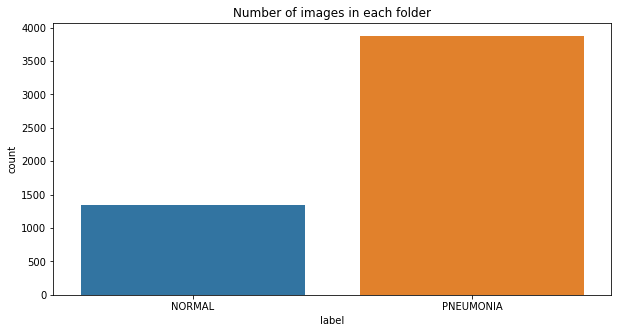

In [7]:
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=df)
plt.title('Number of images in each folder')
plt.show()


In [8]:
#VGG19 model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
# create the base pre-trained model
base_model = VGG19(weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [9]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=30,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(dataframe=df[:4000],
                                                    directory=None,
                                                    x_col='image',
                                                    y_col='label',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 3998 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [11]:
# This is a similar generator, for validation data
validation_generator = test_datagen.flow_from_dataframe(dataframe=df[4000:],
                                                        directory=None,
                                                        x_col='image',
                                                        y_col='label',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='categorical')

Found 1218 validated image filenames belonging to 1 classes.


In [17]:
# Train the model
history = model.fit_generator(train_generator,
                                epochs=10,
                                validation_data=validation_generator,
                                validation_steps=10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
125/125 [==============================] - 86s 685ms/step - loss: 0.3550 - accuracy: 0.8374 - val_loss: 2.5655 - val_accuracy: 0.1813
Epoch 2/10
125/125 [==============================] - 85s 677ms/step - loss: 0.3191 - accuracy: 0.8639 - val_loss: 2.0722 - val_accuracy: 0.4719
Epoch 3/10
125/125 [==============================] - 88s 706ms/step - loss: 0.2974 - accuracy: 0.8737 - val_loss: 2.0919 - val_accuracy: 0.3063
Epoch 4/10
125/125 [==============================] - 83s 664ms/step - loss: 0.2840 - accuracy: 0.8774 - val_loss: 3.5181 - val_accuracy: 0.0531
Epoch 5/10
125/125 [==============================] - 83s 662ms/step - loss: 0.2759 - accuracy: 0.8777 - val_loss: 2.4363 - val_accuracy: 0.1375
Epoch 6/10
125/125 [==============================] - 83s 666ms/step - loss: 0.2601 - accuracy: 0.8922 - val_loss: 3.7972 - val_accuracy: 0.0625
Epoch 7/10
125/125 [==============================] - 83s 665ms/step - loss: 0.2665 - accuracy: 0.8877 - val_loss: 2.8943 - val_ac

In [18]:
# Plot the training and validation accuracy and loss at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
print('Training accuracy: ', acc)
print('Validation accuracy: ', val_acc)
print('Training loss: ', loss)
print('Validation loss: ', val_loss)


Training accuracy:  [0.8374187350273132, 0.8639319539070129, 0.8736868500709534, 0.8774387240409851, 0.8776888251304626, 0.8921961188316345, 0.8876938223838806, 0.9012005925178528, 0.9019509553909302, 0.8999499678611755]
Validation accuracy:  [0.18125000596046448, 0.47187501192092896, 0.3062500059604645, 0.05312500149011612, 0.13750000298023224, 0.0625, 0.17499999701976776, 0.07187499850988388, 0.2593750059604645, 0.08437500149011612]
Training loss:  [0.35503333806991577, 0.3190601170063019, 0.2974449694156647, 0.28401434421539307, 0.27590709924697876, 0.2601495385169983, 0.2665036618709564, 0.2440917044878006, 0.24661876261234283, 0.23532424867153168]
Validation loss:  [2.565490245819092, 2.0722105503082275, 2.0918960571289062, 3.5181312561035156, 2.436314105987549, 3.7972443103790283, 2.894254207611084, 3.5913376808166504, 2.065802812576294, 3.347449541091919]


Text(0.5, 1.0, 'Training and Validation Accuracy')

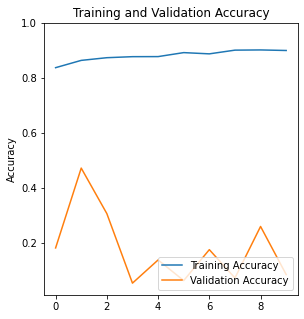

In [19]:
#Plot accuracy and loss curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


In [20]:
#Predict images
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
import numpy as np
img_path = 'Pneumonia//NORMAL/IM-0115-0001.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 224, 224, 3)


In [21]:
#Predict
preds = model.predict(x)
print('Predicted:', preds)


Predicted: [[1.000000e+00 2.772708e-31]]


In [25]:
# Save the model
model.save('Pneumonia.h5')